In [2]:
#import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler,Normalizer
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample,shuffle

#import lightgbm as lgb
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [3]:
#load in the data
df = pd.read_csv('./promotion/train.csv')
df.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [4]:
#split into train and test

train_df = df.iloc[:int(df.shape[0]*0.8)]
test_df = df.iloc[int(df.shape[0]*0.8):]

In [5]:
#data cleaning - train_df
train_df.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [6]:
import datetime

today = datetime.date.today()
today.year

2024

In [7]:
train_df.shape

(30649, 19)

In [8]:
#change year of birth and Year of Recruitment to age

def year_replace(df):
    #get current year
    today = datetime.date.today()
    year = today.year
    df['Age'] = year - df['Year_of_birth']
    df['Age_of_recruitment'] = year - df['Year_of_recruitment']
    
    #drop year_of_birth and year_of_recruitment.
    df = df.drop(['Year_of_recruitment','Year_of_birth'],axis=1)
    return df

train_df = year_replace(train_df)

In [9]:
#drop EmployeeNo
train_df = train_df.drop(['EmployeeNo'],axis=1)

In [10]:
#check for null or missing values
train_df.isnull().sum()

Division                                  0
Qualification                          1359
Gender                                    0
Channel_of_Recruitment                    0
Trainings_Attended                        0
Last_performance_score                    0
Targets_met                               0
Previous_Award                            0
Training_score_average                    0
State_Of_Origin                           0
Foreign_schooled                          0
Marital_Status                            0
Past_Disciplinary_Action                  0
Previous_IntraDepartmental_Movement       0
No_of_previous_employers                  0
Promoted_or_Not                           0
Age                                       0
Age_of_recruitment                        0
dtype: int64

In [11]:
#replace null values in Qualification with "No degree class"
train_df.Qualification = train_df.Qualification.fillna('No degree')

#leave Not_Sure as a category in Marital Status like it is. 
#replace More than 5 in No_of_previous_emplyers with 6
train_df.No_of_previous_employers = train_df.No_of_previous_employers.replace('More than 5','6')

#change column to int.
train_df.No_of_previous_employers = train_df.No_of_previous_employers.astype(int)

In [12]:
train_df.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,Age,Age_of_recruitment
0,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,12.5,1,0,41,ANAMBRA,No,Married,No,No,0,0,38,13
1,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,12.5,0,0,52,ANAMBRA,Yes,Married,No,No,0,0,33,9
2,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,7.5,0,0,42,KATSINA,Yes,Married,No,No,0,0,37,12
3,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,2.5,0,0,42,NIGER,Yes,Single,No,No,1,0,42,15
4,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,7.5,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0,34,12


In [17]:
train_df.shape

(56108, 18)

In [13]:
train_df['Promoted_or_Not'].value_counts()

0    28054
1     2595
Name: Promoted_or_Not, dtype: int64

In [14]:
train_df[train_df['Promoted_or_Not'] != 1].shape[0]

28054

In [15]:
#upsampling the lower class
df_1 = train_df[train_df['Promoted_or_Not'] == 1]

#set other classes to another dataframe
other_df = train_df[train_df['Promoted_or_Not'] != 1]  

#upsample the minority class
df_1_upsampled = resample(df_1,random_state=42,n_samples=other_df.shape[0],replace=True)

#concatenate the upsampled dataframe
train_df = pd.concat([df_1_upsampled,other_df])

In [16]:
train_df['Promoted_or_Not'].value_counts()

1    28054
0    28054
Name: Promoted_or_Not, dtype: int64

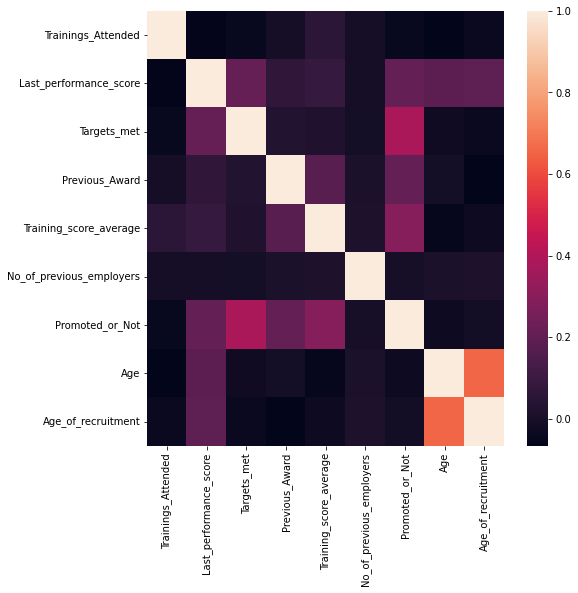

In [34]:
import seaborn as sns
fig = plt.figure(figsize=(8,8))
sns.heatmap(train_df.corr())
fig.show()

In [14]:
y = train_df['Promoted_or_Not']
X = train_df.drop(['Promoted_or_Not'],axis=1)

#split the dataset into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
#encodings
train_df.dtypes

Division                                object
Qualification                           object
Gender                                  object
Channel_of_Recruitment                  object
Trainings_Attended                       int64
Last_performance_score                 float64
Targets_met                              int64
Previous_Award                           int64
Training_score_average                   int64
State_Of_Origin                         object
Foreign_schooled                        object
Marital_Status                          object
Past_Disciplinary_Action                object
Previous_IntraDepartmental_Movement     object
No_of_previous_employers                 int64
Promoted_or_Not                          int64
Age                                      int64
Age_of_recruitment                       int64
dtype: object

In [16]:
train_df.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,Age,Age_of_recruitment
10110,Sourcing and Purchasing,First Degree or HND,Female,Agency and others,2,0.0,1,1,55,ONDO,Yes,Married,No,No,1,1,29,5
15502,Customer Support and Field Operations,First Degree or HND,Male,Direct Internal process,2,7.5,1,1,58,KATSINA,Yes,Married,No,No,1,1,35,11
13386,Sourcing and Purchasing,First Degree or HND,Female,Agency and others,2,12.5,1,0,62,BENUE,Yes,Married,No,No,1,1,54,14
13020,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,2,12.5,1,0,39,ONDO,Yes,Married,No,No,0,1,31,6
19743,Information and Strategy,First Degree or HND,Female,Agency and others,3,0.0,1,0,75,LAGOS,Yes,Married,No,No,0,1,28,5


### Model Development

In [17]:
#Label Encoding the color column
from sklearn.preprocessing import LabelEncoder

#instantiate the Label Encoder
le = ce.OrdinalEncoder(cols=['Division','Gender','Channel_of_Recruitment','Marital_Status'])

#instantiate encoders
ce_base = ce.BaseNEncoder(cols=['State_Of_Origin'],base=5)

#instantiate encoders
ce_one = ce.OneHotEncoder(cols=['Qualification','Foreign_schooled','Past_Disciplinary_Action',
                                'Previous_IntraDepartmental_Movement'])

In [18]:
X_train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Age,Age_of_recruitment
706,Customer Support and Field Operations,First Degree or HND,Male,Direct Internal process,2,12.5,0,0,60,ADAMAWA,Yes,Married,No,No,0,29,8
26343,Information Technology and Solution Support,"MSc, MBA and PhD",Female,Agency and others,3,5.0,0,0,74,ABIA,No,Married,No,No,2,36,11
18254,Information Technology and Solution Support,"MSc, MBA and PhD",Male,Agency and others,3,7.5,1,0,75,AKWA IBOM,Yes,Single,No,No,1,35,7
15133,Commercial Sales and Marketing,No degree,Female,Direct Internal process,2,2.5,0,0,41,IMO,Yes,Married,No,No,1,53,11
2675,Information Technology and Solution Support,"MSc, MBA and PhD",Male,Direct Internal process,2,12.5,0,0,84,LAGOS,Yes,Married,No,No,0,38,14


#### Logistic Regression

In [19]:
#set up the column transfomer
ct = ColumnTransformer([
        ('transformer', Normalizer(norm='l1'), ['Age','Age_of_recruitment'])
    ], remainder='passthrough')

In [20]:
#Build pipeline
pipe_lr = Pipeline([('ordinal_encoder', le),
                    ('basen_encoder', ce_base),
                    ('onehot_encoder', ce_one),
                    ('transformer', ct),
                    ('logistic', LogisticRegression(solver='liblinear'))])

#fit the pipeline
pipe_lr.fit(X_train,y_train)

#make predictions
preds = pipe_lr.predict(X_test)

In [21]:
#Test model accuracy with f1_score
f1_score(y_test, preds, average='macro')

0.724613295724766

#### Gradient Boosted Trees

In [22]:
lgbc = lgb.LGBMClassifier(learning_rate=0.1,n_estimators=1000,max_depth=5,num_leaves=50,n_jobs=-1)

#Build pipeline
pipe_gb = Pipeline([('ordinal_encoder', le),
                    ('basen_encoder', ce_base),
                    ('onehot_encoder', ce_one),
                    ('transformer', ct),
                    ('gradient boosting', lgbc)])

#fit the pipeline
pipe_gb.fit(X_train,y_train)

#make predictions
preds_gb = pipe_gb.predict(X_test)

In [23]:
#Test model accuracy with f1_score
f1_score(y_test, preds_gb, average='macro')

0.9359002827026937